In [25]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle
import csv
import json
import array as array
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import numpy as np

import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat

In [2]:
dir = '/31_07_2019/'

In [52]:
reader = csv.reader(open('data/intercalibration19C.csv', 'r'))
dict_run_cryst = {}
dict_C3_energy_scan = {}
dict_C3_energy_scan_3x3 = {}

for row in reader:
    run,energy,crystal,_ = row
    if energy=='149.12' :
        if crystal in dict_run_cryst.keys() :
            dict_run_cryst[crystal].append(run)
        else : 
            dict_run_cryst[crystal] = []
            dict_run_cryst[crystal].append(run)       
        
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if energy=='149.12' and  (crystal=='C3' or crystal=='C2' or crystal=='C4' ) :
        if crystal in dict_run_cryst.keys() :
            dict_run_cryst[crystal].append(run)
        else : 
            dict_run_cryst[crystal] = []
            dict_run_cryst[crystal].append(run)   
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        
        

##Special run for C3 trigger 3x3 
reader = csv.reader(open('data/energyscans19C_3x3.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row 
    if crystal=='C3' :
        if energy in dict_C3_energy_scan_3x3.keys() :
            dict_C3_energy_scan_3x3[energy].append(run)
        else : 
            dict_C3_energy_scan_3x3[energy] = []
            dict_C3_energy_scan_3x3[energy].append(run)             
#########################Consider 3x3 now      #########################
#dict_C3_energy_scan = dict_C3_energy_scan_3x3
###########################################################################
            
            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')

In [53]:
outstr = 'simoneCenter_1mm'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots//31_07_2019//crystal_E1_map_simoneCenter_1mm.pdf has been created
Info in <TCanvas::Print>: png file plots//31_07_2019//crystal_E1_map_simoneCenter_1mm.png has been created


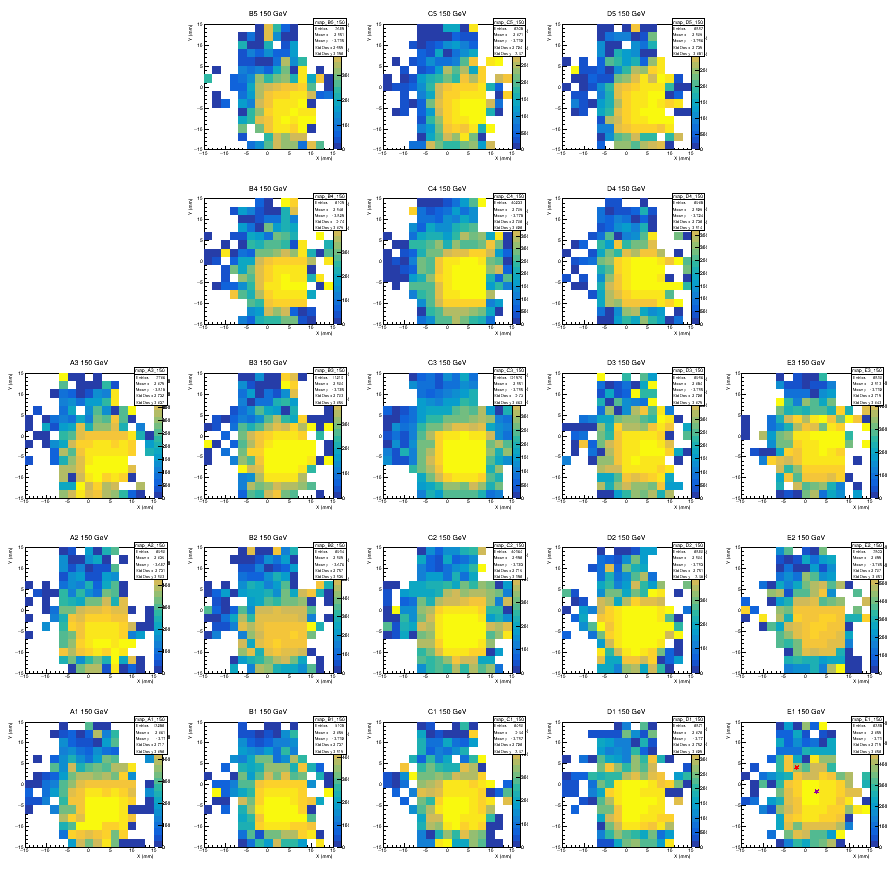

In [55]:
reload(crystMap)

canvas_num=0
c = ROOT.TCanvas("c","c",900,900)
c.Divide(5,5)
energy='150'
for crystal in naming:
    if crystal in missing:
        canvas_num+=1
    else :
        c.cd(canvas_num+1)
        runs = dict_run_cryst[crystal]

#c = ROOT.TCanvas("c","c",2000,400)
#c.Divide(5,1)
#crystal='C3'
#energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
#energies = [str(item) for item in energies]
#for energy in energies :
#        c.cd(canvas_num+1) 
#        runs = dict_C3_energy_scan[energy]

        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)
        
        crystal_map = crystMap.CrystalMap(tree)
        crystal_map.set_crystal(crystal)
        crystal_map.set_energy(energy)
        crystal_map.set_selection()
        
        crystal_map.nbins = 6
        crystal_map.xmin = -5
        crystal_map.xmax = 15
        crystal_map.ymin = -5
        crystal_map.ymax = 15
        
        crystal_map.plot(dict_crystal_centers)
 
        canvas_num+=1
c.Draw()
c.SaveAs('plots/%s/crystal_%s_map_%s.pdf'%(dir,crystal,outstr))
c.SaveAs('plots/%s/crystal_%s_map_%s.png'%(dir,crystal,outstr))


In [ ]:
pos_cut = 1
c = ROOT.TCanvas("c","c",900,900)
c.Divide(5,5)
canvas_num=0
results = []
for crystal in naming:
    if crystal in missing:
        canvas_num+=1
    else :
        c.cd(canvas_num+1) 
        
        runs = dict_run_cryst[crystal]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)
    
        myCB = CB.CBfunction(tree)
        myCB.set_crystal(crystal)
        myCB.set_energy('150')
        myCB.set_position(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut)
        myCB.prepare_histogram()
        myCB.CBintialization()
        myCB.fitToData()
        myCB.plot()
        tmp_dict = {}
        tmp_dict[crystal] = myCB.fitResults()
        results.append(tmp_dict)
        
        canvas_num+=1
c.Draw()
c.SaveAs('plots/%s/intercalibration_fits_%s.pdf'%(dir,outstr))
c.SaveAs('plots/%s/intercalibration_fits_%s.png'%(dir,outstr))
with open('output/%s/intercalibration_%s.json'%(dir,outstr), 'w') as fp:
    json.dump(results,fp)
    
dict_crystals_calibration = {}
meanC3 = 1.
for item in results:
    if item.keys()[0] == 'C3' :
        meanC3 = item['C3']['CBmean'][0]
for item in results:
    dict_crystals_calibration[item.keys()[0]] = meanC3/item[item.keys()[0]]['CBmean'][0]

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_fit_C3_49.99): fit range of variable signal_C3_50GeV expanded to nearest bin boundaries: [355,1065] --> [340,1080]
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **  236 **SET PRINT           1
 **********
 **********
 **  237 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha_C3_49.99   5.00000e-01  2.00000e+00   -1.00000e+01  1.00000e+01
     2 exp_C3_49.99   7.00000e+00  3.00000e+00    0.00000e+00  3.00000e+01
     3 mean_C3_49.99   7.10000e+02  7.10000e+01    3.55000e+02  1.06500e+03
     4 sigma_C3_49.99   6.00000e+01  2.50000e+01    1.00000e+01  5.00000e+02
 **********
 **  238 **SET ERR         0.5
 **********
 **********
 **  239 **SET PRINT           1
 **********
 **********
 **  240 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **  241 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots//31_07_2019//C3_fits_simoneCenter_1mm_3x3trigger.pdf has been created
Info in <TCanvas::Print>: pdf file plots//31_07_2019//C3_fits_simoneCenter_1mm_3x3trigger.pdf has been created


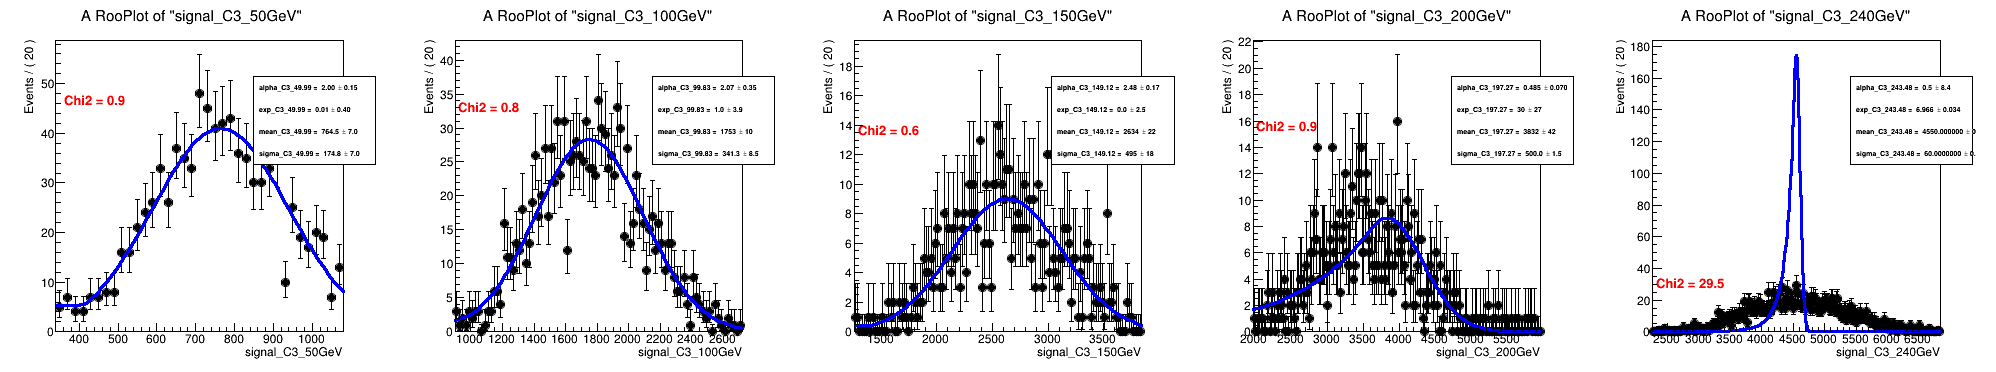

In [7]:
pos_cut = 1

c = ROOT.TCanvas("c","c",2000,400)
c.Divide(5,1)
canvas_num=0
C3_results = []
crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]
for energy in energies :
        c.cd(canvas_num+1) 
        
        runs = dict_C3_energy_scan[energy]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)
        
        myCB = CB.CBfunction(tree)
        myCB.set_crystal(crystal)
        myCB.set_energy(energy)
        myCB.set_position(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut)
        
        myCB.xaxis_scale = 0.5
        
        myCB.prepare_histogram()
        myCB.CBintialization()
        myCB.fitToData()
        myCB.plot()
        tmp_dict = {}
        tmp_dict[energy] = myCB.fitResults()
        C3_results.append(tmp_dict)
        
        canvas_num+=1
        
c.Draw()
c.SaveAs('plots/%s/C3_fits_%s.pdf'%(dir,outstr))
c.SaveAs('plots/%s/C3_fits_%s.pdf'%(dir,outstr))

with open('output/%s/energyscans_C3_results_%s.json'%(dir,outstr), 'w') as fp:
    json.dump(C3_results,fp)

fit parametes and 1-sigma errors:
	 par[0] = 32.426 +- 0.007
	 par[1] = -37.318 +- 0.677
ADC to GeV convesion factor = 0.024


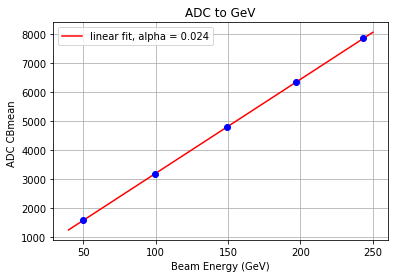

In [17]:
energies_float = []
means_C3 = []
means_unc_C3  = []
for item in C3_results:
    energies_float.append((float)(item.keys()[0]))
    means_C3.append(item[item.keys()[0]]['CBmean'][0])
    means_unc_C3.append(item[item.keys()[0]]['CBmean'][1])
    
def linear_func(x, a, b):
    return a * x + b

fig, ax = plt.subplots()
#ax.plot(energies_float, means_C3,'bo' )
ax.errorbar(energies_float, means_C3, yerr=means_unc_C3,fmt='bo')
popt, pcov = curve_fit(linear_func, energies_float, means_C3, sigma=means_unc_C3,absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print('fit parametes and 1-sigma errors:')
for i in range(len(popt)):
    print('\t par[%d] = %.3f +- %.3f'%(i,popt[i],perr[i]))


shower_energy = 0.79
conversion_factor = shower_energy/popt[0]
print 'ADC to GeV convesion factor = %.3f'%conversion_factor


xfine = np.linspace(40., 250., 1000)  # define values to plot the function for
ax.plot(xfine, linear_func(xfine, popt[0], popt[1]), 'r-',label='linear fit, alpha = %.3f'%conversion_factor)
ax.set(xlabel='Beam Energy (GeV)', ylabel='ADC CBmean ',
       title='ADC to GeV')

plt.legend()
plt.grid()
plt.show()
fig.savefig('plots/%s/ADC_to_GeV_%s.png'%(dir,outstr))
fig.savefig('plots/%s/ADC_to_GeV_%s.pdf'%(dir,outstr))


dict_crystals_calibration['conversion_factor'] = conversion_factor
with open('output/%s/conversion_factor_%s.json'%(dir,outstr), 'w') as fp:
    json.dump(dict_crystals_calibration, fp)

# Sum of energies in matrix 3x3 and 5x5

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_fit_C3_49.99): fit range of variable signal_C3_50GeV expanded to nearest bin boundaries: [1893.48,2178.52] --> [1888,2184]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(signal_C3_49.99_Int[signal_C3_50GeV]) using numeric integrator RooIntegrator1D to calculate Int(signal_C3_50GeV)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **  226 **SET PRINT           1
 **********
 **********
 **  227 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha2_C3_49.99   5.00000e-01  2.00000e+00   -1.00000e+01  1.00000e+01
     2 alpha_C3_49.99   1.50000e+00  2.00000e+00   -1.00000e+01  1.00000e+01
     3 exp2_C3_49.99   7.00000e+00  3.00000e+00    0.00000e+00  3.00000e+01
     4 exp_C3_49.99   1.70000e+00  8.50000e-01    0.00000e+00  3.00000e+01
     5 mean_C3_49.99   2.03600e+03  2.85040e+01    1.89348e+03  2.17852e+03
 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots//31_07_2019//Sum5_fits_simoneCenter_1mm.pdf has been created
Info in <TCanvas::Print>: pdf file plots//31_07_2019//Sum5_fits_simoneCenter_1mm.pdf has been created


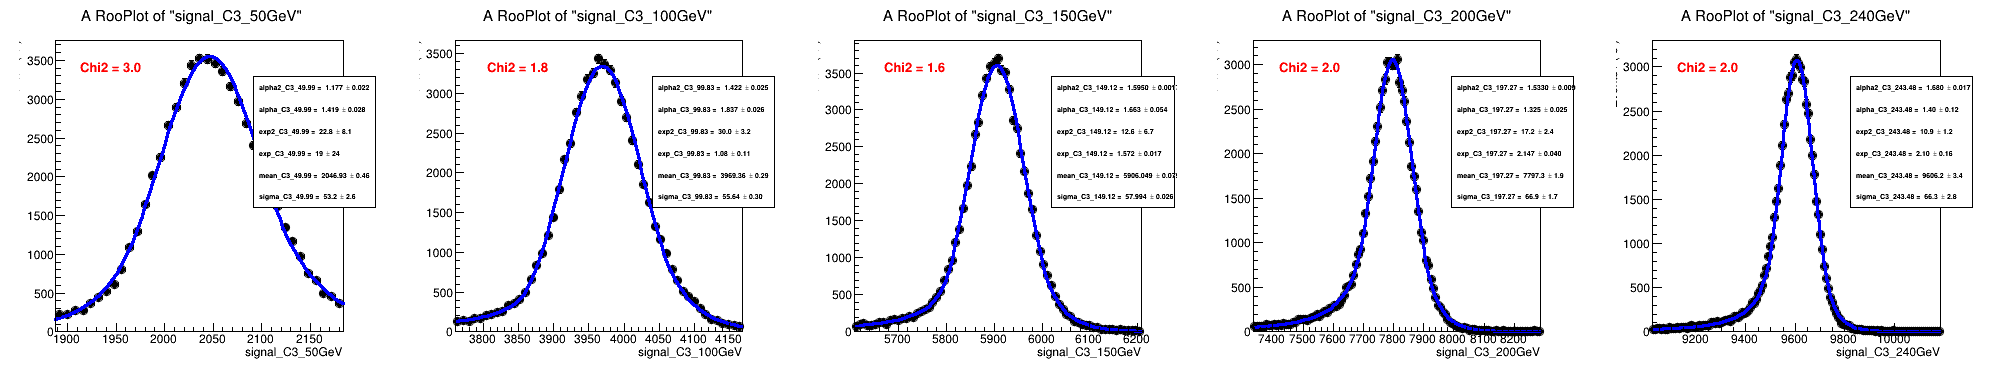

In [34]:
reload(CB)

pos_cut = 4
c = ROOT.TCanvas("c","c",2000,400)
c.Divide(5,1)
canvas_num=0
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]
crystal='C3'
which_matrix == 3
if which_matrix == 5 :
    matrix=matrix_5
    Sum5_results = []
if which_matrix == 3 :
    matrix=matrix_3
    Sum3_results = []
for energy in energies :      
        c.cd(canvas_num+1) 
        
        runs = dict_C3_energy_scan[energy]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)
        
        myCB = CB.CBfunction(tree)
        myCB.doubleSidedCB = True
        myCB.nbins = 1500
       # myCB.xmin = 0
       # myCB.xmax = 300
        myCB.xaxis_scale = 0.1
        myCB.a_initial = 1.5
        myCB.n_initial = 1.7
        myCB.xaxis_scale = 0.06

        if (float)(energy) <= 150 : 
            myCB.s_initial = 27
            myCB.xaxis_scale = 0.05
            if (which_matrix==5) and (float)(energy) <= 60 : 
                myCB.xaxis_scale = 0.07



        myCB.set_crystal(crystal)
        myCB.set_energy(energy)
        myCB.set_position(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut)
        myCB.prepare_sumhistogram(dict_crystals_calibration,matrix)
        
        if myCB.doubleSidedCB==True : 
            myCB.CB2intialization()
        else : myCB.CBintialization()
        myCB.fitToData()
        myCB.plot()
        tmp_dict = {}
        tmp_dict[energy] = myCB.fitResults()
        if which_matrix==3 : Sum3_results.append(tmp_dict)
        if which_matrix==5 : Sum5_results.append(tmp_dict)
        
        
        canvas_num+=1
        
c.Draw()
c.SaveAs('plots/%s/Sum%d_fits_%s.pdf'%(dir,which_matrix,outstr))
c.SaveAs('plots/%s/Sum%d_fits_%s.png'%(dir,which_matrix,outstr))

with open('output/%s/Sum%d_results_%s.json'%(dir,which_matrix,outstr), 'w') as fp:
    if which_matrix==3 : json.dump(Sum3_results,fp)    
    if which_matrix==5 : json.dump(Sum5_results,fp)    

In [36]:
gROOT.ProcessLineSync(".x utils/setTDRStyle.C")
gROOT.ForceStyle()
gStyle.SetPadTopMargin(0.06)
gStyle.SetPadRightMargin(0.04)
gStyle.SetPadLeftMargin(0.2)

fit parametes and 1-sigma errors:
	 par[0] = 38.828 +- 0.001
	 par[1] = -45.408 +- 0.132
ADC to GeV convesion factor = 0.026


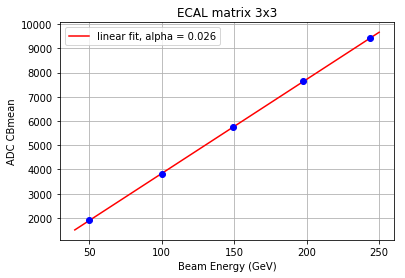

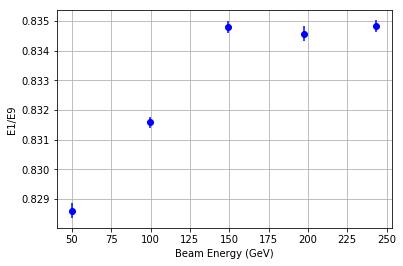

fit parametes and 1-sigma errors:
	 par[0] = 39.065 +- 0.004
	 par[1] = 80.313 +- 0.545
ADC to GeV convesion factor = 0.026


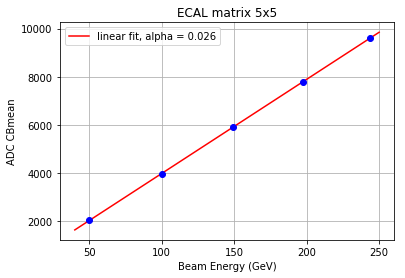

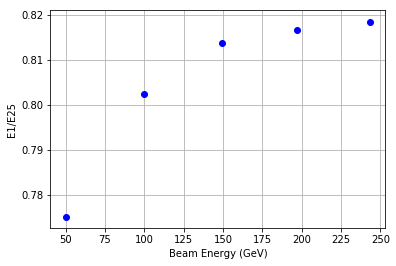

Info in <TCanvas::Print>: pdf file plots//31_07_2019//EnergyResolution_sum3_simoneCenter_1mm.pdf has been created
Info in <TCanvas::Print>: png file plots//31_07_2019//EnergyResolution_sum3_simoneCenter_1mm.png has been created
Info in <TCanvas::Print>: pdf file plots//31_07_2019//EnergyResolution_sum5_simoneCenter_1mm.pdf has been created
Info in <TCanvas::Print>: png file plots//31_07_2019//EnergyResolution_sum5_simoneCenter_1mm.png has been created


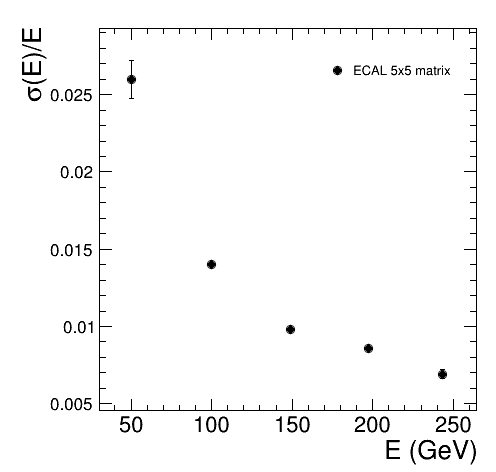

In [41]:
def linear_func(x, a, b):
    return a * x + b


beam_scan_resolution = 0.005

for which_matrix in [3,5]:
    
    if which_matrix == 3 :
        Sum_results = Sum3_results
        shower_energy_sum = 1.0 #or 0.95 ?
    
    if which_matrix == 5 :
        Sum_results = Sum5_results  
        shower_energy_sum = 1.0 #or 0.95 ?
    
        
    energies_float = []
    means_sum = []
    means_unc_sum  = []
    sigmas_sum = []
    sigmas_unc_sum  = []
    sigma_over_mean_sum = []
    energies_float_unc = []
    
    for num,item in enumerate(Sum_results):
        energies_float.append((float)(item.keys()[0])) 
        energies_float_unc.append( (float)(item.keys()[0])*beam_scan_resolution )
        means_sum.append(item[item.keys()[0]]['CBmean'][0])
        means_unc_sum.append(item[item.keys()[0]]['CBmean'][1])
        sigmas_sum.append(item[item.keys()[0]]['CBsigma'][0])
        sigmas_unc_sum.append(item[item.keys()[0]]['CBsigma'][1])
        #sigma_over_mean_sum.append(sigmas_sum[num]/means_sum[num])

    e1_over_esum = unumpy.umatrix(means_C3, means_unc_C3)/unumpy.umatrix(means_sum, means_unc_sum)
    
    means =  unumpy.umatrix(means_sum, means_unc_sum)
    sigmas =  unumpy.umatrix(sigmas_sum, sigmas_unc_sum)
    sigma_over_mean_sum = sigmas/means
    

    
    fig, ax = plt.subplots()
    #ax.plot(energies_float, means_sum,'bo' )
    ax.errorbar(energies_float, means_sum, yerr=means_unc_sum,fmt='bo')
    popt, pcov = curve_fit(linear_func, energies_float, means_sum, sigma=means_unc_sum,absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    print('fit parametes and 1-sigma errors:')
    for i in range(len(popt)):
        print('\t par[%d] = %.3f +- %.3f'%(i,popt[i],perr[i]))

    conversion_factor_sum = shower_energy_sum/popt[0]
    print 'ADC to GeV convesion factor = %.3f'%conversion_factor_sum

    xfine = np.linspace(40., 250., 1000)  # define values to plot the function for
    ax.plot(xfine, linear_func(xfine, popt[0], popt[1]), 'r-',label='linear fit, alpha = %.3f'%conversion_factor_sum)
    ax.set(xlabel='Beam Energy (GeV)', ylabel='ADC CBmean',
        title='ECAL matrix %dx%d'%(which_matrix,which_matrix))

    plt.legend()
    plt.grid()
    plt.show()
    fig.savefig('plots/%s/ADC_to_GeV_sum%d_%s.png'%(dir,which_matrix,outstr))
    fig.savefig('plots/%s/ADC_to_GeV_sum%d_%s.pdf'%(dir,which_matrix,outstr))
    
    fig, ax = plt.subplots()
    ax.errorbar(energies_float,unumpy.nominal_values(e1_over_esum).tolist()[0], yerr=unumpy.std_devs(e1_over_esum).tolist()[0],fmt='bo')
    ax.set(xlabel='Beam Energy (GeV)', ylabel='E1/E%d'%(which_matrix*which_matrix))
    plt.grid()
    plt.show()
    fig.savefig('plots/%s/E1_over_E%d_%s.png'%(dir,which_matrix*which_matrix,outstr))
    fig.savefig('plots/%s/E1_over_E%d_%s.pdf'%(dir,which_matrix*which_matrix,outstr))
    


    dict_crystals_calibration['conversion_factor_sum%d'%which_matrix] = conversion_factor_sum
    with open('output/%s/conversion_factor_%s.json'%(dir,outstr), 'w') as fp:
        json.dump(dict_crystals_calibration, fp)
        

    c1 = ROOT.TCanvas("c_sum%d"%which_matrix,"c_sum%d"%which_matrix,500,500)
    
    y=array.array('d',unumpy.nominal_values(sigma_over_mean_sum).tolist()[0])
    ey=array.array('d',unumpy.std_devs(sigma_over_mean_sum).tolist()[0])
    gr = ROOT.TGraphErrors(len(energies_float),array.array('d',energies_float),y,array.array('d',energies_float_unc) ,ey )
    gr.SetMarkerStyle( 20 )

    gr.SetTitle('')
    gr.GetYaxis().SetLabelSize(0.04)
    gr.GetYaxis().SetLabelSize(0.04)
    gr.GetYaxis().SetTitleOffset(1.35)
    gr.GetYaxis().SetTitle( '#sigma(E)/E' )
    gr.GetXaxis().SetTitle( 'E (GeV)' )
    gr.Draw( 'AP' )
    leg = ROOT.TLegend(0.65,0.8,0.9,0.9)
    leg.SetFillStyle(-1)
    leg.SetBorderSize(0)
    leg.SetTextFont(42)
    leg.SetTextSize(0.03)
    leg.AddEntry(gr,'ECAL %dx%d matrix'%(which_matrix,which_matrix),'P')
    leg.Draw()

    c1.Draw()  
    c1.SaveAs('plots/%s/EnergyResolution_sum%d_%s.pdf'%(dir,which_matrix,outstr))
    c1.SaveAs('plots/%s/EnergyResolution_sum%d_%s.png'%(dir,which_matrix,outstr))

        